In [54]:


import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms
from tqdm import tqdm
import numpy as np



from resnetpass import resnet18_cbam

In [141]:
config = {
    "lr":0.001,
    "prot_aug":True,
    "subcenter_margin":0.28,
    "subcenters":3,
    "backbone":"efficientnet",
    "pretrained":False,
}

In [142]:
!pip install timm

Defaulting to user installation because normal site-packages is not writeable


In [143]:
import timm
from resnetpass import resnet18_cbam


if config['backbone'] == 'efficientnet':
    model = timm.create_model('efficientnet_b3', pretrained=config['pretrained'])
    model.classifier = nn.Linear(model.classifier.in_features, 512)
elif config['backbone'] == 'efficientnetv2':
    model = torchvision.models.efficientnet_v2_s()
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, 512)
elif config['backbone'] == 'rn18':
    model = resnet18_cbam(pretrained=False)
    model.fc = nn.Linear(512,512)

In [144]:
model

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
      

In [147]:
import torchsummary

torchsummary.summary(model, (3, 224, 224),device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
          Identity-2         [-1, 32, 112, 112]               0
              SiLU-3         [-1, 32, 112, 112]               0
    BatchNormAct2d-4         [-1, 32, 112, 112]              64
            Conv2d-5         [-1, 32, 112, 112]             288
          Identity-6         [-1, 32, 112, 112]               0
              SiLU-7         [-1, 32, 112, 112]               0
    BatchNormAct2d-8         [-1, 32, 112, 112]              64
            Conv2d-9              [-1, 8, 1, 1]             264
             SiLU-10              [-1, 8, 1, 1]               0
           Conv2d-11             [-1, 32, 1, 1]             288
          Sigmoid-12             [-1, 32, 1, 1]               0
    SqueezeExcite-13         [-1, 32, 112, 112]               0
           Conv2d-14         [-1, 16, 1

In [56]:
device = torch.device('cuda:0')
class_order_file = 'class_order.pth'

In [57]:
!pip install pytorch-metric-learning

Defaulting to user installation because normal site-packages is not writeable


In [69]:
#model.load_state_dict(model_state_dict['rn18'])
import os

if os.path.isfile(class_order_file ):
    class_order = torch.load(class_order_file)
else:
    class_order = torch.randperm(100)
    torch.save(class_order,class_order_file)

In [70]:
class_order

tensor([27, 16, 74, 19, 36, 39, 31, 95, 35, 70, 51, 99, 38, 15, 49, 13, 52, 33,
         0, 84, 96, 73, 92, 40, 60, 54, 83, 75, 68, 76, 50,  4, 71, 20, 77, 59,
         6, 42, 26, 22,  1, 97, 21, 58, 18, 85, 28, 34, 24, 69, 55, 81, 46, 94,
        41, 25, 47, 45, 93, 67, 89, 32,  8, 63, 30,  2, 91, 23, 90, 44, 65, 53,
        66,  7, 61, 14, 82, 72, 56, 29, 12, 64,  9,  3, 86, 88, 98, 78, 80, 79,
        57, 11,  5, 43, 87, 62, 48, 10, 17, 37])

In [71]:
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
])

In [72]:
ds_train = datasets.CIFAR100(root='./data', train=True, download=True, transform=preprocess)
ds_test  = datasets.CIFAR100(root='./data', train=False, download=True, transform=preprocess)

Files already downloaded and verified
Files already downloaded and verified


In [73]:
def instances_from_classes(dataset, class_order):
    subset = []
    for i in range(len(dataset)):
        _, label = dataset[i]
        if label in class_order:
            subset.append(i)
    return subset


In [74]:
set_train = instances_from_classes(ds_train,class_order[:50])
set_test  = np.array(instances_from_classes(ds_test, class_order[:50]))

In [75]:
set_test.shape

(5000,)

In [151]:
actual_n_class = 0
total_classes = 100
step_size = 10

In [152]:
steps = (total_classes - actual_n_class)//step_size

In [153]:
folds = []
for i in range(steps):
    actual_n_class =  i*step_size
    print(actual_n_class,actual_n_class+step_size)
    folds.append(instances_from_classes(ds_train,class_order[actual_n_class:actual_n_class+step_size]))

0 10
10 20
20 30
30 40
40 50
50 60
60 70
70 80
80 90
90 100


In [154]:
len(folds[0])

5000

In [155]:
def sample_from_fold(fold, percentage=0.1):
    n = len(fold)
    return sorted(np.random.choice(fold, int(n*percentage), replace=False))


In [91]:
sub = sample_from_fold(folds[0],0.1)

In [101]:
targets = np.array(ds_train.targets)

In [104]:
np.unique(targets[sub],return_counts=True)

(array([25, 41, 45, 46, 47, 55, 67, 81, 93, 94]),
 array([52, 56, 59, 41, 51, 50, 43, 55, 47, 46]))

In [76]:
sub_sample_train = sorted(np.random.permutation(set_train)[:300])
sub_sample_test  = sorted(np.random.permutation(set_test)[:300])

In [212]:
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=64, sampler=torch.utils.data.SubsetRandomSampler(set_train))
dl_test = torch.utils.data.DataLoader(ds_test,  batch_size=64, sampler=torch.utils.data.SubsetRandomSampler(set_test))
dl_sub_train = torch.utils.data.DataLoader(ds_train,  batch_size=64, sampler=torch.utils.data.SubsetRandomSampler(sub_sample_train))
dl_sub_test = torch.utils.data.DataLoader(ds_test,  batch_size=64, sampler=torch.utils.data.SubsetRandomSampler(sub_sample_test))

In [213]:
x,y = next(iter(dl_train))

In [214]:
y.shape

torch.Size([64])

In [215]:
y

tensor([18, 95, 13, 54, 16,  0, 97, 52, 92, 51, 73, 27, 26, 52, 34, 49, 83, 31,
        24, 31,  4, 34, 85, 38, 92, 52, 71, 96, 84, 60, 77, 95, 49, 73, 95, 27,
        58, 58, 92, 26, 71, 76, 13, 54, 22, 95, 73, 39, 38, 24, 34, 49, 38, 16,
        38, 59, 38, 38, 42, 19, 33, 26, 60, 58])

In [132]:
from pytorch_metric_learning import losses
loss_func = losses.SubCenterArcFaceLoss(num_classes=100,embedding_size=512,margin=config['subcenter_margin'],sub_centers=config['subcenters'])


In [217]:
!pip install wandb

Defaulting to user installation because normal site-packages is not writeable


In [218]:
import wandb

In [204]:
wandb.init(
    # set the wandb project where this run will be logged
    project="dmil",
    config=config
)

In [109]:

opt = optim.Adam(model.parameters(),lr=config['lr'])

In [110]:
scheduler = optim.lr_scheduler.MultiStepLR(opt,milestones=[45,90],gamma=0.1)

In [111]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (ca): ChannelAttention(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (max_pool): AdaptiveMaxPool2d(output_size=1)
        (fc1): Conv2d(64, 4, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (relu1): ReLU()
        (fc2

In [112]:
emb_batch = model(x.to(device))

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1712608839953/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:84.)
  return F.conv2d(input, weight, bias, self.stride,


In [113]:
from sklearn.manifold import TSNE

In [114]:
# given a batch of instances create a surrounding sample of instances
def create_surrounding_batch(batch,batch_y, num_surrounding=100, size=0.001):
    surrounding_batch = []
    surrounding_batch_y = []
    for i in range(len(batch)):
        
        instances_sorrounding = batch[i]+(torch.randn(num_surrounding,512)*size).to(batch.device)
        surrounding_batch.append(instances_sorrounding)
        surrounding_batch_y.append(batch_y[i].repeat(num_surrounding))
    return torch.cat(surrounding_batch), torch.cat(surrounding_batch_y)

In [115]:
batch_emb, batch_y = create_surrounding_batch(emb_batch,y)

In [116]:
batch_emb.shape

torch.Size([6400, 512])

In [117]:
batch_y.shape

torch.Size([6400])

In [118]:

tsne = TSNE(2, verbose=1)
tsne_proj = tsne.fit_transform(batch_emb.to('cpu').detach().numpy())

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6400 samples in 0.001s...
[t-SNE] Computed neighbors for 6400 samples in 0.402s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6400
[t-SNE] Computed conditional probabilities for sample 2000 / 6400
[t-SNE] Computed conditional probabilities for sample 3000 / 6400
[t-SNE] Computed conditional probabilities for sample 4000 / 6400
[t-SNE] Computed conditional probabilities for sample 5000 / 6400
[t-SNE] Computed conditional probabilities for sample 6000 / 6400
[t-SNE] Computed conditional probabilities for sample 6400 / 6400
[t-SNE] Mean sigma: 0.005555
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.149902
[t-SNE] KL divergence after 1000 iterations: 0.935209


In [119]:
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable


In [120]:
from matplotlib import cm
import matplotlib.pyplot as plt

In [121]:
def tsne_proj(batch_emb, batch_y):
    tsne = TSNE(2, verbose=1)
    tsne_proj = tsne.fit_transform(batch_emb.to('cpu').detach().numpy())
    cmap = cm.get_cmap('tab10')
    fig, ax = plt.subplots(figsize=(15,15))
    num_categories = 100
    for lab in range(num_categories):
        if lab in batch_y:
            indices = batch_y==lab
            ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = lab ,alpha=0.5)
    ax.legend(fontsize='large', markerscale=2)
    plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6400 samples in 0.001s...
[t-SNE] Computed neighbors for 6400 samples in 0.394s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6400
[t-SNE] Computed conditional probabilities for sample 2000 / 6400
[t-SNE] Computed conditional probabilities for sample 3000 / 6400
[t-SNE] Computed conditional probabilities for sample 4000 / 6400
[t-SNE] Computed conditional probabilities for sample 5000 / 6400
[t-SNE] Computed conditional probabilities for sample 6000 / 6400
[t-SNE] Computed conditional probabilities for sample 6400 / 6400
[t-SNE] Mean sigma: 0.005555
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.153416
[t-SNE] KL divergence after 1000 iterations: 0.935391


/tmp/ipykernel_21077/3286734825.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


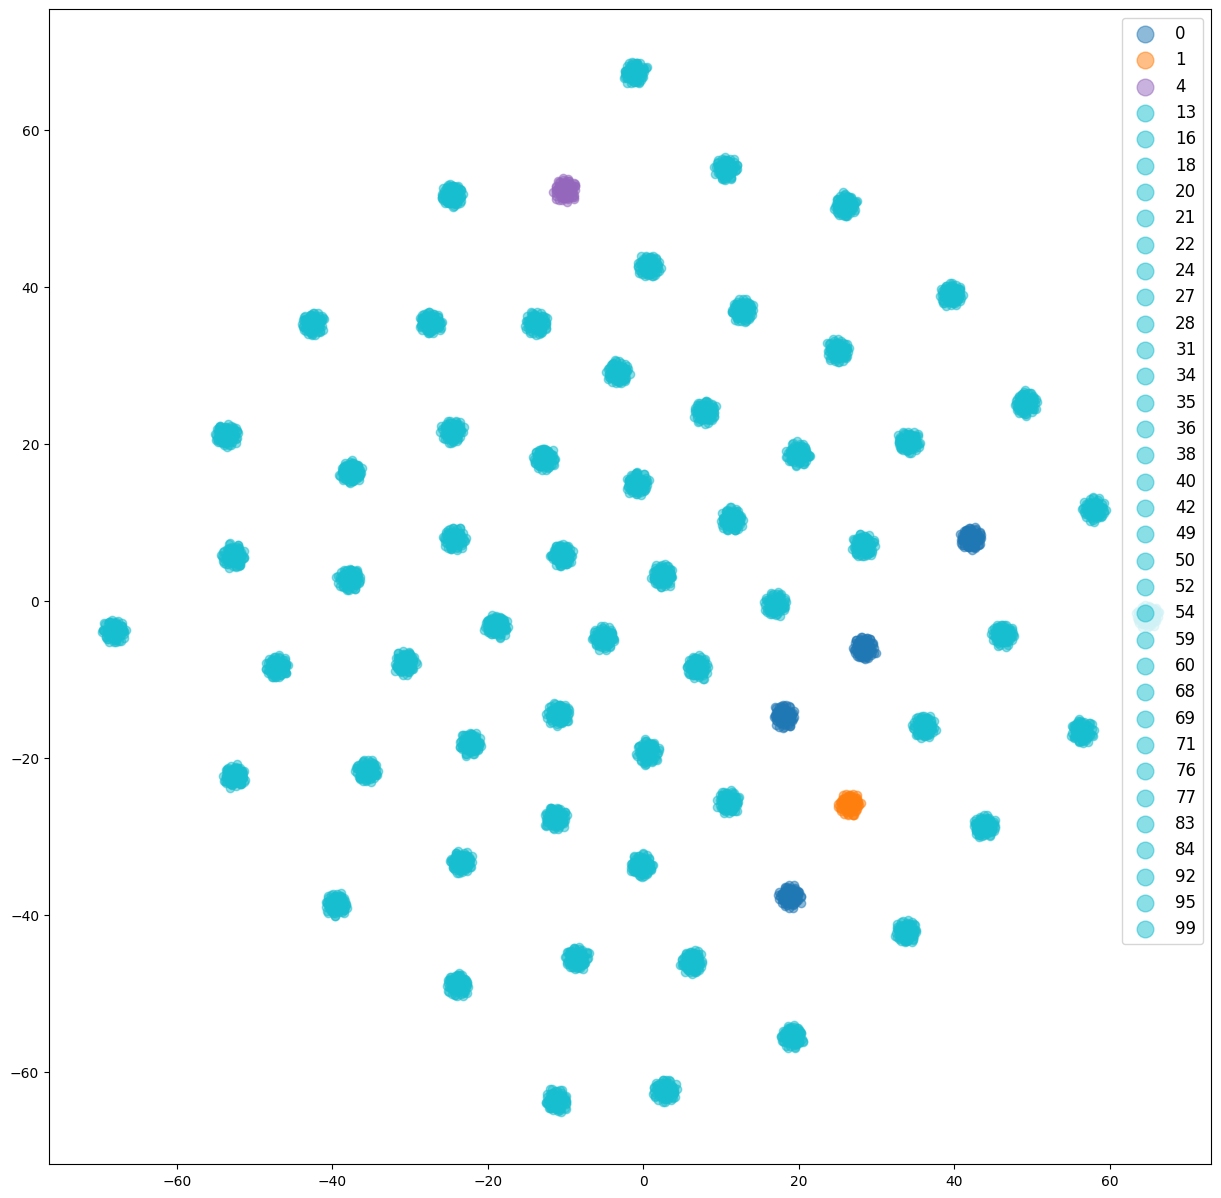

In [122]:
#tsne_proj(batch_emb,batch_y)

In [123]:
def get_embeddings(lmodel,dl):
    lmodel.to(device)
    loop = tqdm(dl)
    lpred = []
    ly = []
    with torch.no_grad():
        for x,y in loop:
            x = x.to(device)
            y = y.to(device)
            pred = lmodel(x)
            lpred = lpred+pred.tolist()
            ly    = ly + y.tolist()
    return lpred,ly

In [124]:
import sklearn.neighbors as neighbors

In [125]:
from sklearn.metrics import classification_report

In [126]:
def pred_knn_model(model,dl_local_train,dl_local_test):
    train_emb,train_y = get_embeddings(model,dl_local_train)
    test_emb,test_y   = get_embeddings(model,dl_local_test)
    train_emb  = np.array(train_emb)
    train_y    = np.array(train_y)
    test_emb   = np.array(test_emb)
    test_y     = np.array(test_y)
    clf = neighbors.KNeighborsClassifier(n_neighbors=1,weights='distance')
    clf.fit(train_emb,train_y.T)
    pred = clf.predict(test_emb)
    return pred,test_y


In [127]:
pred,test_y = pred_knn_model(model,dl_sub_train,dl_sub_test)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 84.37it/s]


In [128]:
pred.shape,test_y.T.shape

((300,), (300,))

In [129]:
print(classification_report(test_y.T,pred))

              precision    recall  f1-score   support

           0       0.25      0.30      0.27        10
           1       0.33      0.33      0.33         3
           4       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         5
          13       0.00      0.00      0.00        10
          15       0.00      0.00      0.00         7
          16       0.00      0.00      0.00         6
          18       0.00      0.00      0.00         8
          19       0.00      0.00      0.00         5
          20       0.33      0.12      0.18         8
          21       0.00      0.00      0.00         4
          22       0.00      0.00      0.00         5
          24       0.21      0.25      0.23        12
          26       0.00      0.00      0.00         5
          27       0.00      0.00      0.00         4
          28       0.00      0.00      0.00         4
          31       0.00      0.00      0.00         6
          33       0.17    

/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [130]:
import sklearn.metrics as metrics

In [180]:
small_sample = []
for fold in folds:
    small_sample.append(sample_from_fold(fold,0.1))
small_sample = np.array(small_sample)    

In [181]:
small_sample.shape

(10, 500)

In [196]:
actual_sample = small_sample[:4].flatten()

In [197]:
actual_sample

array([    0,    10,   356, ..., 49792, 49855, 49931])

In [198]:
actual_sample  = np.concatenate([actual_sample,small_sample[5]])

In [199]:
actual_sample.shape

(2500,)

In [202]:
folds[5]

[32,
 36,
 41,
 56,
 59,
 61,
 77,
 90,
 99,
 100,
 105,
 112,
 122,
 125,
 159,
 185,
 186,
 190,
 191,
 196,
 197,
 203,
 211,
 213,
 234,
 241,
 259,
 267,
 284,
 291,
 380,
 394,
 401,
 426,
 438,
 447,
 450,
 489,
 493,
 500,
 503,
 508,
 538,
 552,
 553,
 556,
 557,
 614,
 626,
 642,
 654,
 666,
 667,
 673,
 674,
 675,
 688,
 695,
 703,
 709,
 715,
 725,
 730,
 736,
 741,
 757,
 770,
 783,
 817,
 820,
 828,
 846,
 850,
 860,
 873,
 885,
 892,
 893,
 909,
 925,
 948,
 965,
 975,
 998,
 1006,
 1014,
 1025,
 1027,
 1030,
 1050,
 1060,
 1073,
 1078,
 1079,
 1088,
 1101,
 1105,
 1121,
 1151,
 1152,
 1187,
 1188,
 1189,
 1196,
 1202,
 1204,
 1207,
 1216,
 1222,
 1224,
 1227,
 1228,
 1241,
 1247,
 1250,
 1256,
 1257,
 1262,
 1297,
 1305,
 1307,
 1340,
 1354,
 1356,
 1366,
 1381,
 1382,
 1387,
 1392,
 1395,
 1408,
 1412,
 1429,
 1435,
 1443,
 1462,
 1466,
 1471,
 1473,
 1481,
 1483,
 1487,
 1488,
 1519,
 1521,
 1540,
 1544,
 1563,
 1582,
 1615,
 1617,
 1620,
 1623,
 1627,
 1628,
 1633,
 

In [203]:
model_sample = np.concatenate([actual_sample,folds[5]])

In [206]:
pred,labels = pred_knn_model(model,dl_train,dl_test)
f1 = metrics.f1_score(labels,pred,average='macro')
precision = metrics.precision_score(labels,pred,average='macro')
recall = metrics.recall_score(labels,pred,average='macro')
accuracy = metrics.accuracy_score(labels,pred)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 36.37it/s]
/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [207]:
print(f1,precision,recall,accuracy)

0.009901120700857009 0.022875021200502013 0.006833333333333334 0.0082


In [205]:
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=64, sampler=torch.utils.data.SubsetRandomSampler(model_sample))

In [133]:
model.to(device)
loss_func.to(device)
loss_train = []
for epoch in range(100):
    model.train()
    loop = tqdm(dl_train)
    lloss = []
    for data, labels in loop:
        data = data.to(device)
        labels = labels.to(device)
        opt.zero_grad()
        embeddings = model(data)
        if config['prot_aug']:
            embeddings,labels = create_surrounding_batch(embeddings,labels)
        loss = loss_func(embeddings, labels)
        loss.backward()
        lloss.append(loss.item())
        opt.step()
    scheduler.step()
    if epoch %10 == 0:
        pred,labels = pred_knn_model(model,dl_sub_train,dl_sub_test)
        f1 = metrics.f1_score(labels,pred,average='macro')
        precision = metrics.precision_score(labels,pred,average='macro')
        recall = metrics.recall_score(labels,pred,average='macro')
        accuracy = metrics.accuracy_score(labels,pred)
        wandb.log({'precision':precision,'recall':recall,'f1':f1,'accuracy':accuracy},step=epoch)
        print(classification_report(labels.T,pred))
    loss_train.append(np.mean(lloss))
    print(f"loss {loss_train[-1]}")
    wandb.log({'loss_train':loss_train[-1]},step=epoch)

 11%|███████████▏                                                                                          | 43/391 [00:02<00:23, 14.79it/s]


KeyboardInterrupt: 

In [ ]:
epoch

99

In [ ]:
pred,labels = pred_knn_model(model,dl_train,dl_test)
f1 = metrics.f1_score(labels,pred,average='macro')
precision = metrics.precision_score(labels,pred,average='macro')
recall = metrics.recall_score(labels,pred,average='macro')
accuracy = metrics.accuracy_score(labels,pred)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.76it/s]


In [ ]:
print(f"precision {precision}")
print(f"recall {recall}")
print(f"f1 {f1}")
print(f"accuracy {accuracy}")

precision 0.712587293484485
recall 0.6336
f1 0.6604739660252084
accuracy 0.6336


precision 0.6781332025178556
recall 0.6264
f1 0.6407966031823693
accuracy 0.6264

In [ ]:
wandb.log({'precision':precision,'recall':recall,'f1':f1,'accuracy':accuracy},step=epoch)
print(classification_report(labels.T,pred))

              precision    recall  f1-score   support

           0       0.87      0.79      0.83       100
           1       0.50      0.82      0.62       100
           4       0.54      0.43      0.48       100
           6       0.77      0.64      0.70       100
          13       0.71      0.67      0.69       100
          15       0.58      0.53      0.55       100
          16       0.72      0.73      0.72       100
          18       0.59      0.48      0.53       100
          19       0.65      0.45      0.53       100
          20       0.91      0.83      0.87       100
          21       0.76      0.78      0.77       100
          22       0.88      0.57      0.69       100
          24       0.74      0.79      0.76       100
          26       0.76      0.50      0.60       100
          27       0.58      0.48      0.52       100
          28       0.84      0.75      0.79       100
          31       0.67      0.56      0.61       100
          33       0.54    

In [ ]:
torch.cuda.get_device_properties(0)

_CudaDeviceProperties(name='NVIDIA GeForce RTX 3060', major=8, minor=6, total_memory=12044MB, multi_processor_count=28)

In [ ]:
torch.save({'rn18':model.state_dict(),'class_order':class_order,'loss_train':loss_train},'rn18_dml_pass_100epochs.pth')

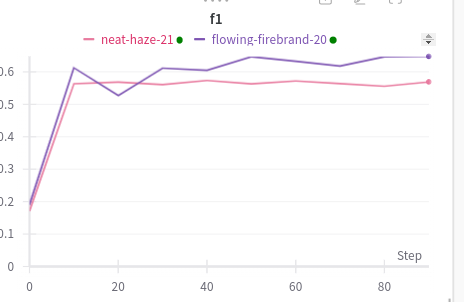

- neat sem a proposta
- flowing com a proposta 